In [175]:
import tensorflow as tf
import torch

In [176]:
from keras.datasets import mnist

In [177]:
import matplotlib.pyplot as plt
import numpy as np

In [178]:
(X_train,y_train),(X_test,y_test) = tf.keras.datasets.mnist.load_data()

In [179]:
print('The shape of the training inputs:', X_train.shape)
print('The shape of the training labels:',y_train.shape)
print('The shape of the testing inputs:',X_test.shape)
print('The shape of the testing labels:',y_test.shape)

The shape of the training inputs: (60000, 28, 28)
The shape of the training labels: (60000,)
The shape of the testing inputs: (10000, 28, 28)
The shape of the testing labels: (10000,)


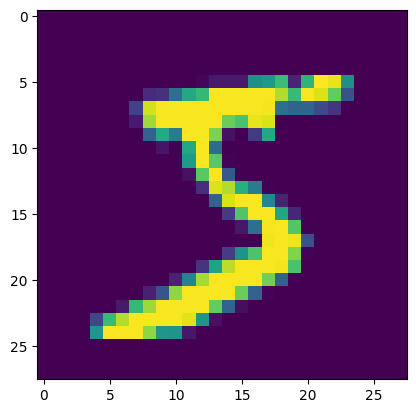

In [180]:
plt.imshow(X_train[0])

In [181]:
X_train=X_train/255
X_test=X_test/255

In [182]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).squeeze(1)
y_train_tensor = torch.tensor(y_train,dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test,dtype=torch.long)

In [183]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

In [184]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

In [185]:
import torch.nn.functional as F

In [186]:
class Model(nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.fc1 = nn.Linear(28*28,256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256,128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.fc4 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(0.2)

    def forward(self,x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        x = self.fc4(x)
        return F.log_softmax(x, dim=1)
model = Model()

In [187]:
lossfn = nn.CrossEntropyLoss()


In [188]:
optimizer = optim.Adam(model.parameters(),lr=0.0001)

In [189]:
nn.init.xavier_uniform_(model.fc1.weight)
nn.init.xavier_uniform_(model.fc2.weight)
nn.init.xavier_uniform_(model.fc3.weight)
nn.init.xavier_uniform_(model.fc4.weight)

Parameter containing:
tensor([[-2.3902e-01,  1.4407e-01, -2.8183e-01, -2.2885e-01, -1.9264e-01,
          1.9529e-01, -7.6559e-02, -1.3031e-02, -1.2433e-01,  1.6561e-01,
         -1.1419e-01, -1.3703e-03,  1.4859e-01, -2.3006e-01,  5.0576e-02,
          1.6595e-02, -1.8095e-01, -2.2965e-01, -1.0823e-01,  8.2317e-02,
          1.9208e-01,  4.8056e-02,  2.0779e-01,  5.8325e-02, -1.0332e-02,
         -5.1756e-02,  9.9334e-02, -1.7204e-01, -1.6981e-02, -7.0572e-02,
         -2.3051e-01,  2.0590e-01, -2.3334e-01,  2.1020e-01, -8.4703e-02,
         -2.1029e-01,  4.7280e-02,  2.0919e-01, -6.5424e-02,  1.9952e-01,
          1.3400e-01,  1.9958e-01, -2.4167e-02,  6.0032e-02, -2.1289e-01,
         -8.6338e-02,  3.2613e-02,  1.5584e-01, -1.2543e-01, -3.4083e-02,
          5.3859e-03,  1.0561e-01,  1.2782e-01, -1.2151e-01,  9.9314e-02,
          2.8065e-01,  1.0348e-01, -2.4631e-01,  1.9761e-01, -1.9601e-01,
          2.1507e-02,  8.0216e-02, -2.2497e-01, -1.6902e-01],
        [ 2.7434e-01,  9.460

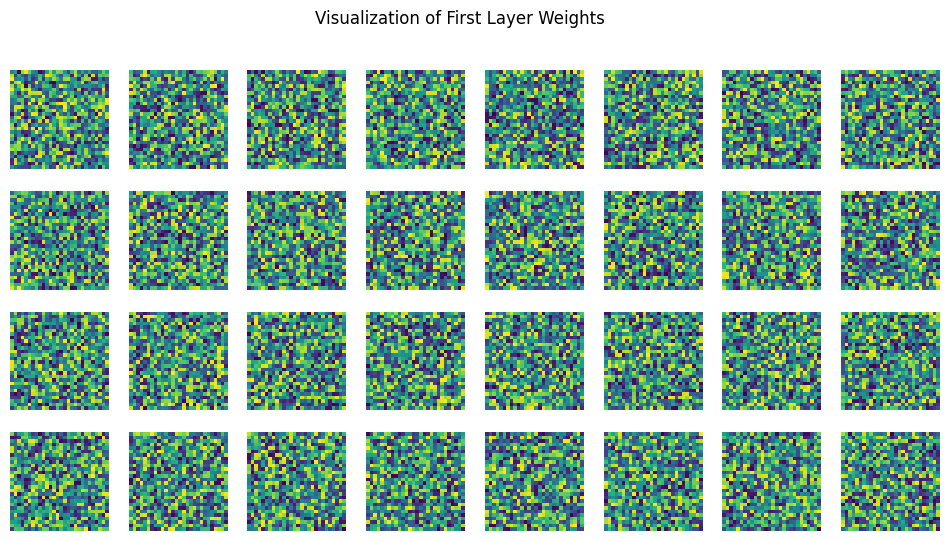

In [190]:
# Extract weights from first fully connected layer
weights = model.fc1.weight.data

# Plot a few neurons' weights as 28x28 images
fig, axes = plt.subplots(4, 8, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    if i < weights.shape[0]:
        ax.imshow(weights[i].reshape(28, 28), cmap='viridis')
        ax.axis('off')
plt.suptitle("Visualization of First Layer Weights")
plt.show()


In [191]:
#training loop
epochs = 10

for epoch in range(epochs):
    model.train()
    running_loss=0

    for image,labels in train_loader:
        
        #set gradients as zero
        optimizer.zero_grad()

        #forward pass
        outputs = model(image)
        loss = lossfn(outputs,labels)

        #backward pass
        loss.backward()

        #optimiser
        optimizer.step()

        running_loss += loss.item()

    if epoch%5==0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):4f}")
    

Epoch 1/10, Loss: 0.972791
Epoch 6/10, Loss: 0.184789


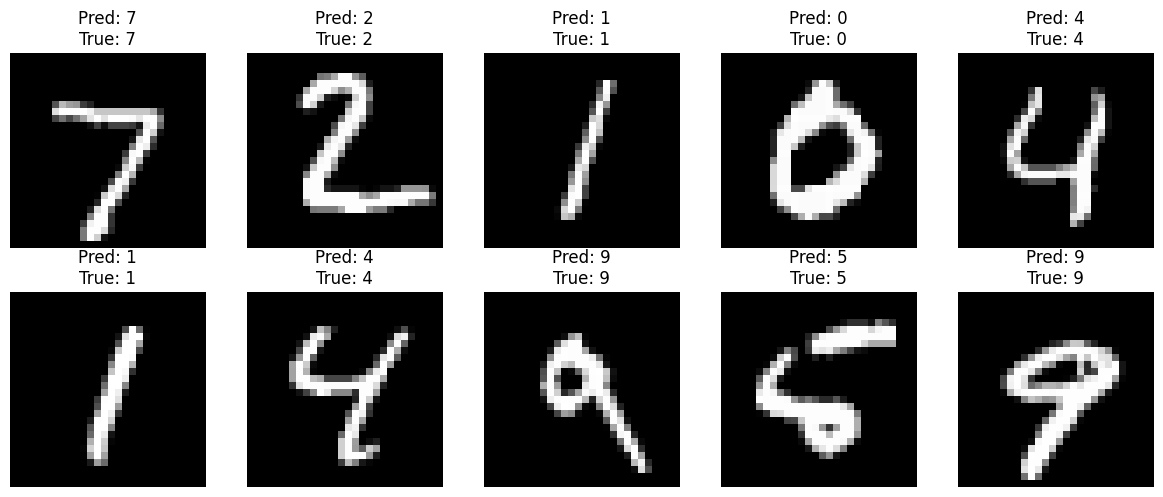

In [193]:
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        break  # Just the first batch

# Plot the first 10 test images and their predictions
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].squeeze(), cmap='gray')
    ax.set_title(f"Pred: {predicted[i].item()}\nTrue: {labels[i].item()}")
    ax.axis('off')
plt.tight_layout()
plt.show()


In [195]:
model.eval()
correct = 0
total=0
wrong=[]
with torch.no_grad():
    for images,labels in test_loader:
        outputs=model(images)

        _,predicted = torch.max(outputs,1)
        total+=labels.size(0)
        correct += (predicted == labels).sum().item() 
        
        for i in range(len(labels)):
            if predicted[i]!=labels[i]:
                wrong.append((images[i], predicted[i], labels[i]))
accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 97.70%


In [196]:
len(wrong)

230

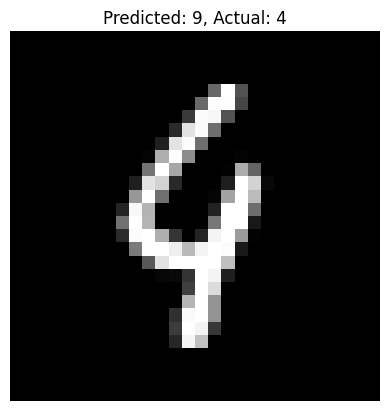

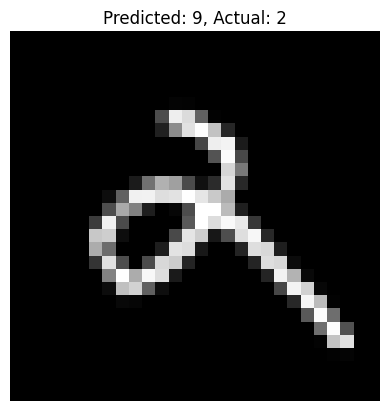

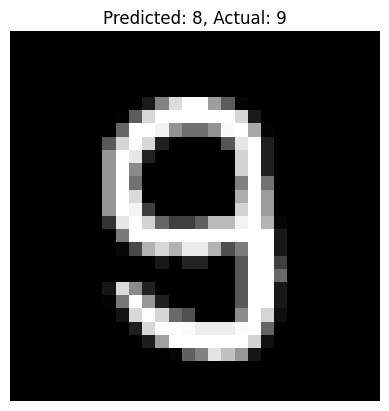

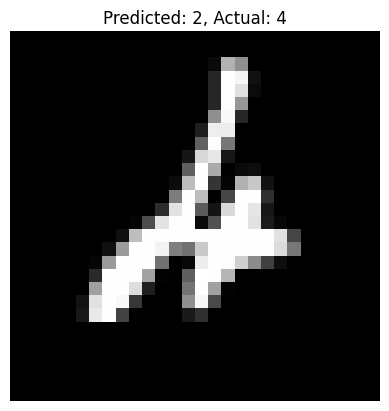

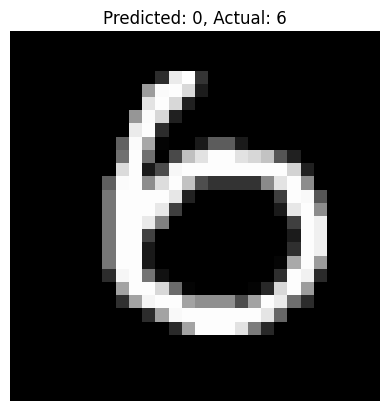

In [199]:
for i in range(5):
    img, pred, true = wrong[i]
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(f"Predicted: {pred.item()}, Actual: {true.item()}")
    plt.axis('off')
    plt.show()